# Projekt do předmětu FYO
## Vidění včelím okem - vizualizace aneb "Jak si namodelovat včelí oko"

Autor: Jan Beran

Tento dokument slouží jako interaktivní vizualizace pro projekt do předmětu FYO - Fyzikální optika. 
Cílem dokumentu je seznámit čtenáře s principem, na jakém funguje včelí oko a rovnou tento princip demonstrovat na vybraném oobrázku. Při vytváření tohoto modelu bylo vycházeno z této [práce](https://www.researchgate.net/publication/322065774_Simulating_Bee_Vision_Conceptualization_Implementation_Evaluation_and_Application_of_a_Raycasting_Rendering_Engine_for_Generating_Bee_Views), celý model je ovšem velmi zjednodušený -- autor původního textu celou problematiku pojal velmi zeširoka a jeho řešení je nepoměrně kvalitnější -- na druhou stranu je velmi názorný a pro základní pochopení funkce včelího oka by měl stačit. 

## Včelí oko

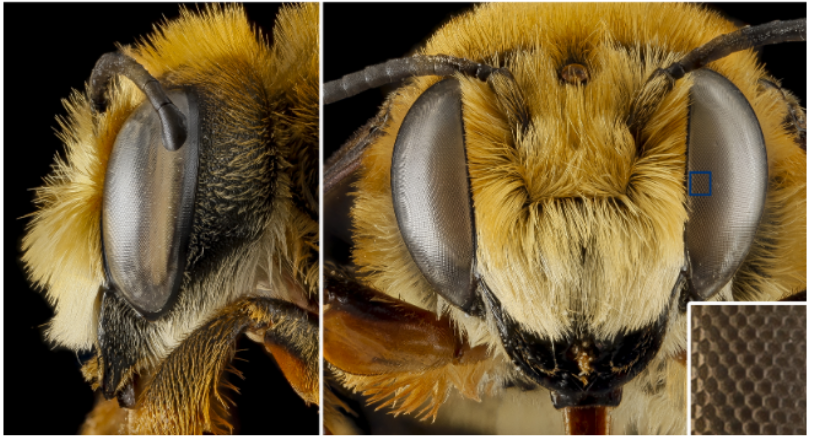

Včelí oko je zástupcem tzv. složeného oka, to znamená, že samotné oko je dále rozděleno na několik tisíc ommatidií -- samostatných světločivných receptorů, které dohromady dávají výsledný obraz. Jednotlivé ommatidium přitom přijímá informaci o barvě a intenzitě jen z určitého prostoru. Tento prostor je definovaný úhlem, který můžete vidět níže: 

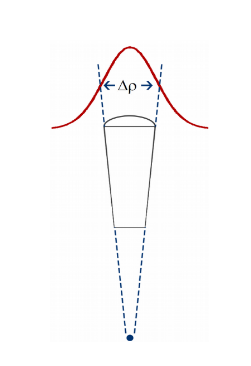



# Popis modelu, ovládání

Celý model je implementován jako soubor krátkých skriptů, spustitelných přímo v prohlížeči.
K nastavení parametrů slouží samostatná buňka, u které bude vysvětlené, jak celý skript ovládat. Pokud nemáte zkušenosti s Google Colab, můžete využít [tento odkaz](https://colab.research.google.com/github/jckantor/CBE30338/blob/master/docs/01.01-Getting-Started-with-Python-and-Jupyter-Notebooks.ipynb). Pro potřeby tohoto dokumentu ale stačí vědět jen to, že buňka se upravuje kliknutím dovnitř a spouští se buď myší pomocí tlačítka "Play" v levém horním rohu buňky, nebo kombinací kláves Shift+Enter, pokud je buňkka právě aktivní. 

Model samotný implementuje složené oko velmi zjednodušeně. Detaily budou rozepsané vždy u příslušné části kódu. Pro začátek je ovšem třeba importovat moduly pro práci s obrázky a matematické operace:

In [198]:
import numpy as np
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
import matplotlib.pylab as plt
from math import sqrt

Dále si importujeme obrázek, který naše včela "uvidí". Dokument zatím podporuje pouze FullHD obrázky (1920x1080). Obrázek je bohužel pouze 2D struktura a proto bude obrazu chybět hloubka. Podrobněji si tuto problematiku rozebereme v dalšch částech.

Spusťte pouze tu buňňku, jejíž obrázek chcete použít. Pokud spustíte projekt pomocí Ctrl+F9, bude použit poslední obrázek. 

In [199]:
url = "http://www.stud.fit.vutbr.cz/~xberan43/1.jpg"

In [200]:
url = "http://www.stud.fit.vutbr.cz/~xberan43/2.jpg"

In [201]:
url = "http://www.stud.fit.vutbr.cz/~xberan43/3.jpg"

In [202]:
# Odkomentujte vybrany obrazek

image = io.imread(url) 

# Z nejakeho duvodu je defaultni format obskurni BGR. Prevedeme si ho do standardniho RGB
image = cv.cvtColor(image, cv.COLOR_BGR2RGB) 


Pokud si chcete zobrazit zdrojový obrázek, spusťťe buňku níže:

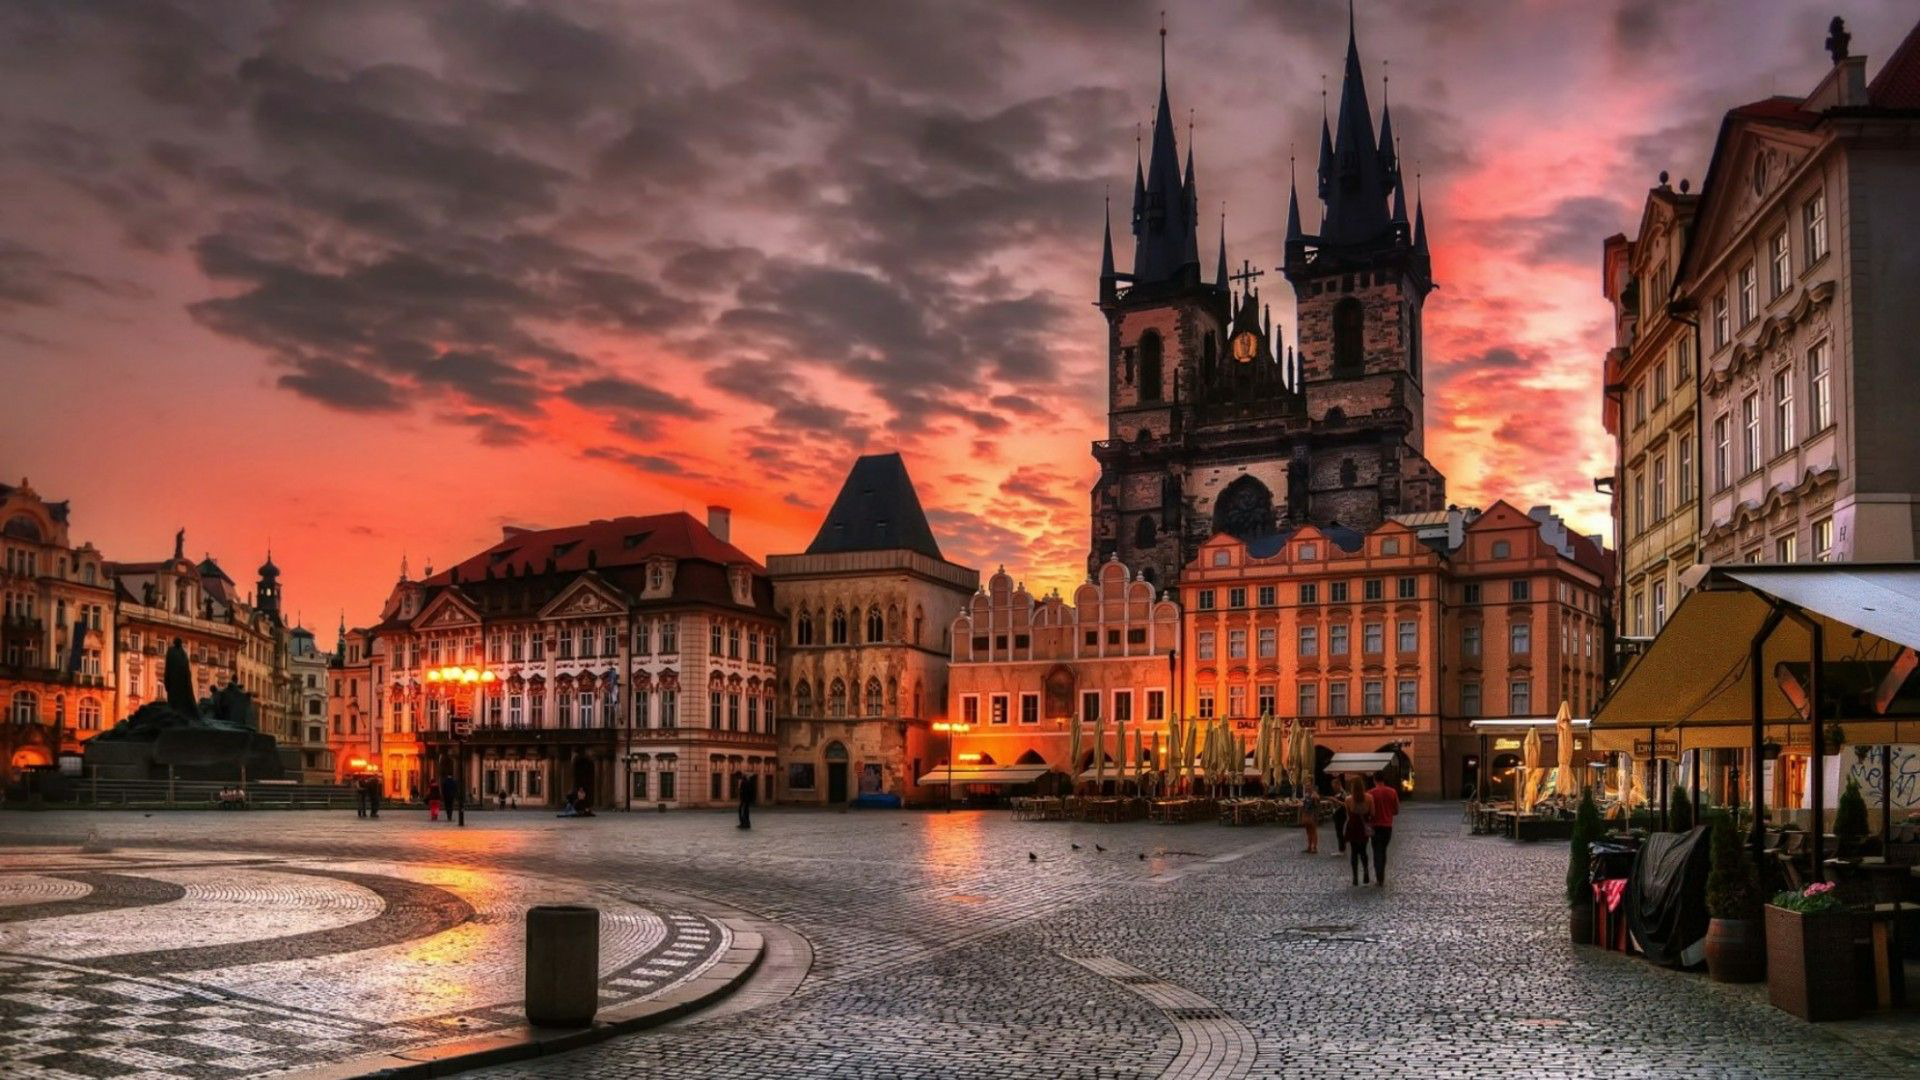

In [203]:
cv2_imshow(image)

# Úprava barevného spektra

Včely mají, na rozdíl od člověka, jiné spektrum vnímaných barev, které se pohybuje cca od 300 do 650 nm (člověk přitom vnímá barvy od 390 do 750 nm). Jelikož obrázek neobsahuje informace o UV spektru, pomůžeme si malým trikem; červená složka je potlačena a modrá naopak posílená. Člověk i včela vnímají zelenou barvu velmi dobře, ta tedy zůstává beze změn. Červená je naproti tomu prakticky odstraněná. "Simulaci" UV záření je řešená tak, že pokud je pixel nadprůměrně modrý (hodnota B větší než polovina), modrá bude zesílená a červená potlačená ještě víc. Tím docílíme alespoň iluze "UV světla". Sice nezískáme přesný obraz "jak ho vidí včela", ale přiblížíme se mu.



In [204]:
# Docasny obrazek
new_image = np.ndarray(image.shape).astype(np.float32)

# Prochazime puvodni obrazek po radcich a sloupcich
for r in range(image.shape[0]):
  for c in range(image.shape[1]):
    px = image[r,c]
    if px[2] > 128: # Pokud je modra slozka nadprumerna...
      new_image[r,c] = [int(px[0]/5), px[1], int(px[2]*2)] # ...provedeme agresivni upravu
    else: 
      new_image[r,c] = [int(px[0]/3), px[1], int(px[2]*1.1)] # jinak "jen" utlumime cervenou a posilime modrou

# Opet upraime barevne schema
image = cv.cvtColor(new_image, cv.COLOR_BGR2RGB)


Pokud chcete, obrázek si opět můžete zobrazit:

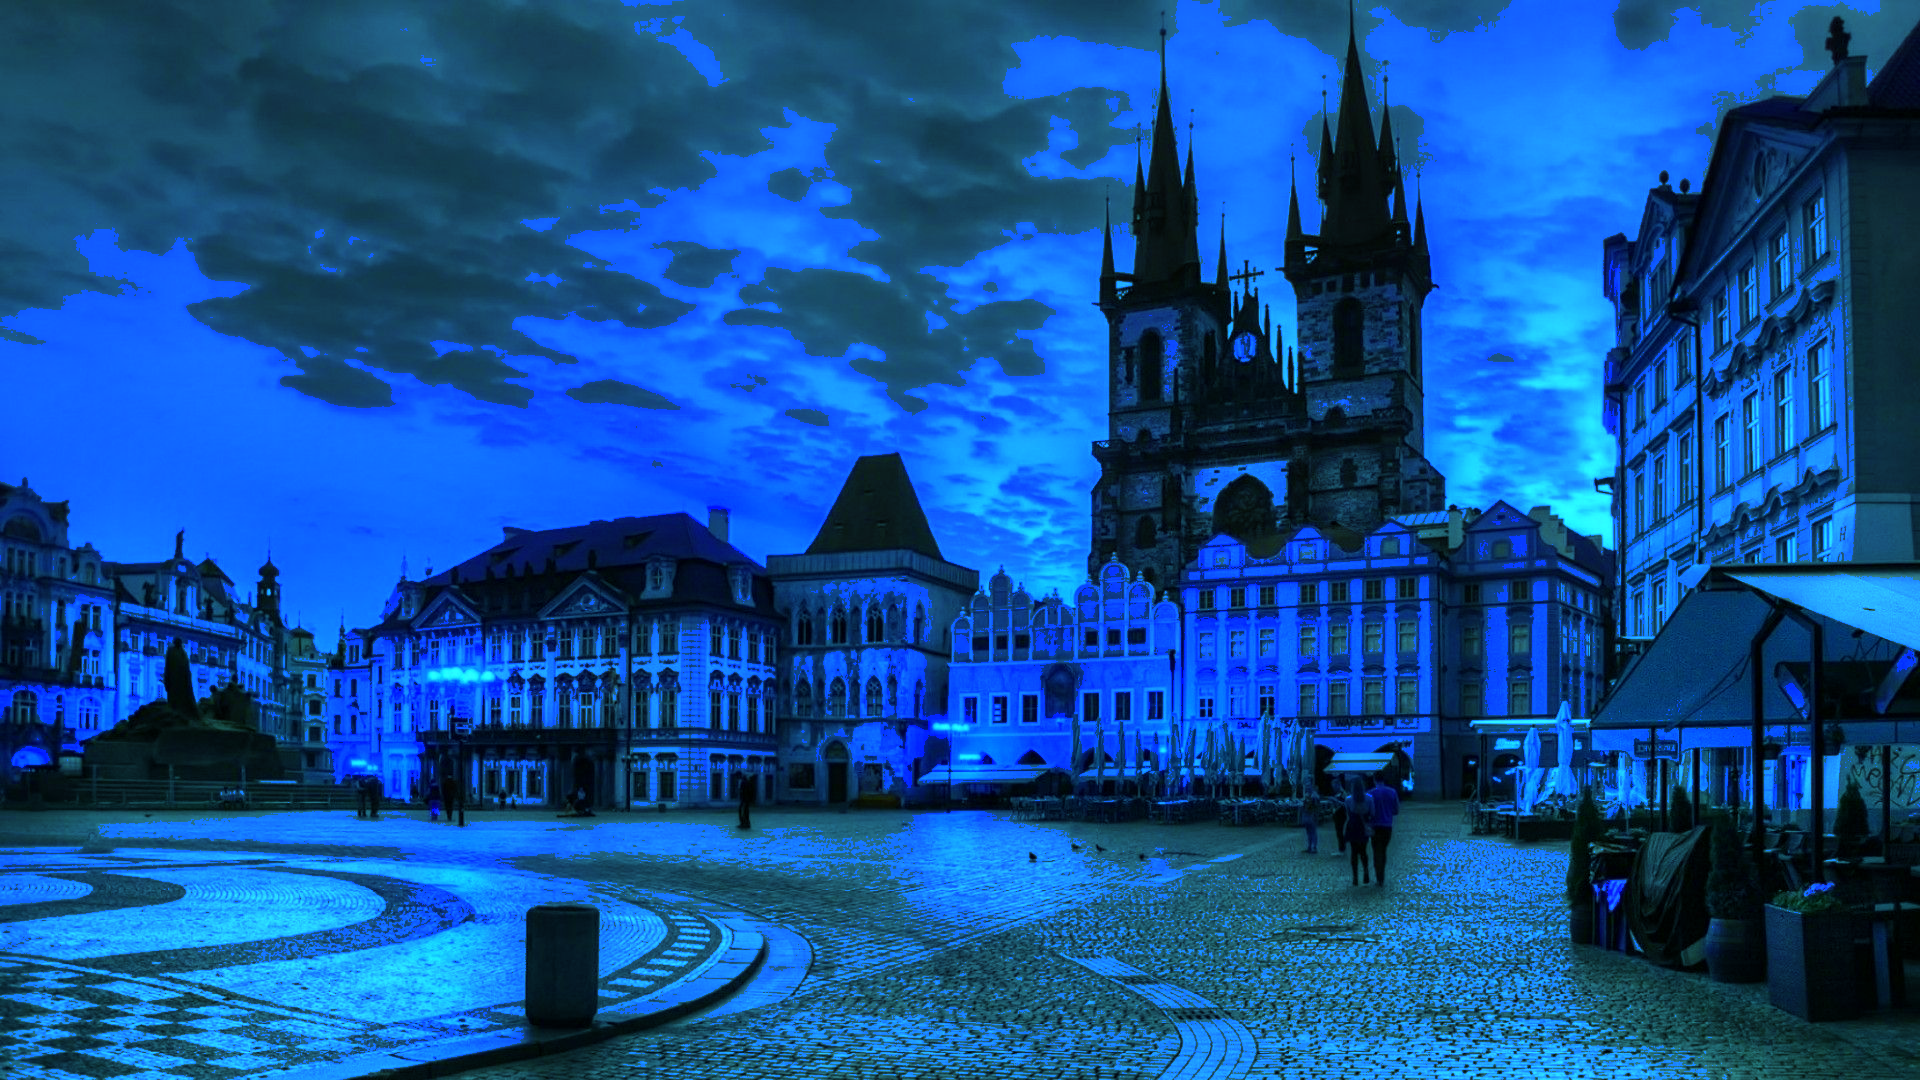

In [205]:
cv2_imshow(image)

# Nastaveni skriptu

V následující buňce dojde k nastavení důležitých hodnot, které ovlivní činnost skriptu:

* resolution [dpi] nám udává rozlišení (pixely na palec), důležitější ale bude odvozená hodnota "pixely na mm". Defaultní hodnota je 100. Vysoké rozlišení bude mít za následek příliš malý obrázek, příliš nízké rozlišení poté rozbije logiku skriptu (některé hodnoty nabudou hodnoty "Strojová nula"). 
* z0 [mm]: vzdálenost "včely" od obrazu. Ideální vzdálenost se pohybuje mezi 20 a 150 mm, při menší vzdálenosti nastavává opět problém strojové nuly, při větší vzdálenosti je obrázek příliš malý a "včela nic nevidí" 
* r, d [mm]: poloměr "oka" a vzájemná vzdálenost jejich středů
* img_rows, img_cols (nastavuje se automaticky): počet pixelů v obrázku v obou rozměrech. Zde si musíme dávat pozor, jelikož nulový bod obrázku je v levém horním rohu a souřadný systém je [rows, cols], musíme toto mít na paměti při přepočtu souřadnic.
* num_ommm: počet ommatidií v každém oku neboli "rozlišení zachyceného obrazu". Reálná včela jich má zhruba 5500, trubci až 9000. Skript zde má drobnou vadu, při vytváření ommatidií v modelu oka jich zhruba 1/3 není použitelná kvůli špatnému umístění ("mimo zorné pole"), pro přibližnou hodnotu 5500 je tedy doporučeno nastavit hodnotu num_omm na 8000. 
* acc_angle je akceptační úhel ommatidia. V praxi nabývá hodnot zhruba 3 stupňů a liší se podle umístění ommatidia. Zde je nastaven na pevnou hodnotu pro všechna ommatidia.
* acc_radius: pomocná proměnná, která určuje, z jakého poloměru na obrázku bude ommatidium přijímat informace o barvě. Zde přitom byl model zjednodušený a vždy se předpokládá oblast ve tvaru kružnice. V reálném světě to platí pouze pro omatidium, které je k obrazu kolmo, ostatní ommatidia mají svůj "akceptační radius" zploštělý podle vzájemného úhlu ommatidia a plochy. 

Ommatidium má jako jednu ze svých vlastností také akceptační funkci (dobře aproximovatelnou pomocí Gaussovy křivky). V tomto modelu je ovšem akceptační funkce konstantní - všechny pixely se podílejí na výsledném obrazu stejně. 

In [206]:
resolution = 100 # dpi,  4 px/mm pro 100 dpi
z0 = 100
r = 1.5 # polomer oka
d = 6 # vzdalenost stredu oci
img_rows = image.shape[0]
img_cols = image.shape[1]
num_omm = 5500
acc_angle = 0.052 #3 stupne  = 0.052 rad 
acc_radius = int(round(acc_angle/2*z0))

Dále potřebujeme nějaké struktury a třídy. 

Třída Vector je jen vylepšený list, který umožňňuje syntaxi v.x a podobně.

Třída Ommatidium obsahuje:
* point, což je bod na povrchu oka
* dir, neboli směr, kterým ommatidium směřuje
* value, což je hodnota, kterou dané ommatidium "vidí"

Třída Eye poté ví, jaký je jeho střed, průměr a jaká má ommatidia. Jeho meotdy přitom nejsou důležité, ve zkratce slouží k vytvoření správného počtu ommatidií. 

In [207]:
# Trida Vector slouzi pouze pro lepsi praci s vektory typu [x,y,z]
class Vector:
  def __init__(self, vec):
    self.data = vec
    self.x = vec[0]
    self.y = vec[1]
    self.z = vec[2]

# Struktura pro uchovavani informaci o kazdem jednom ommatidiu
class Ommatidium:
  def __init__(self, center, point):
    self.point = point # Bod, kde na povrchu "oka" se dane ommatidium nachazi
    self.dir = Vector([point.x-center.x, point.y-center.y, point.z-center.z]) # Smerovy vektor neboli "kam se diva" 
    self.value = [250,250,250] # Hodnota, kterou vidi. Defaultne temer bila
  
# Trida simulujici samotne oko
class Eye:
  def __init__(self, center, radius):
    self.center = center # Stred oka v prostoru
    self.radius = radius # Prumer
    self.ommatidia = list() # Prislusna ommatidia

  # Pomocna funkce. Pro souradnice [x,y] dopocita souradnici z tak, aby bod lezel na povrchu oka
  def get_z(self, x, y):
    temp = self.radius**2 - (x-self.center.x)**2 - (y-self.center.y)**2
    if temp >=0:
      return sqrt (temp)
    else:
       return -sqrt(abs(temp))

  # Pomocna funkce. Pouze urci, zda se dany bod nenachazi "mimo oko"
  def in_circle(self, x, y):
    return True if (((x-self.center.x)**2-(y-self.center.y)**2) <= self.radius**2) else False 

  # Pomocna funkce. Vytvori seznam ommatidii o danem poctu
  def get_ommatidia(self, num):
    # Hranice oka v rovine XY
    min_x = self.center.x-self.radius
    max_x = self.center.x + self.radius
    min_y = self.center.y-self.radius
    max_y = self.center.y+self.radius

    # Startovni souradnice
    x = min_x
    y = min_y

    # Krok - o kolik se lisi vzdalenosti dvou ommatidii
    step = (max_x-min_x)/sqrt(num)
    
    # Hranice pro vypocet, abychom dosahli +- spravneho poctu
    border = int(sqrt(num)//2)    

    for xx in range (-border, +border):
      y = min_y
      x += step
      for yy in range(-border, +border):
        y += step
        if not self.in_circle(x,y):
          continue
        z = self.get_z(x,y)
        if z >= 0:
          self.ommatidia.append(Ommatidium(self.center, Vector([x, y, z])))
          


Nyní už můžeme zahájit první krok simulace. Z náčrtu TODO můžeme vidět, kde se nachází střed celého systému a jednotlivé oči. Vytvoříme si je tedy i v kódu:

In [208]:
# Stredy oci
left = Vector([0,int(d/2),0])
right = Vector([0,-int(d/2),0])

# A samotne oci
left_eye = Eye(left, r)
right_eye = Eye(right, r)

# Navic ronvou vytvorime ommatidia
left_eye.get_ommatidia(num_omm)
right_eye.get_ommatidia(num_omm)

# Ve skutecnosti jsme vytvorili o neco mene ommatidii
# Prikazem nize zjistime kolik
# print(len(left_eye.ommatidia))


Pokud se chceme podívat, jak jsou ommatidia po oku rozprostřená, spustíme si následující buňku. Upozorňňuji, že jeho proveddení může trvat i několik desítek vteřin.  Z výsledku je patrné, že ve středu oka je ommatidií poněkud více - to je naprosto v pořádku, jelikož tím simulujeme reálný stav, kdy je ve středu oka více ommatidií i ve skutečnosti. 

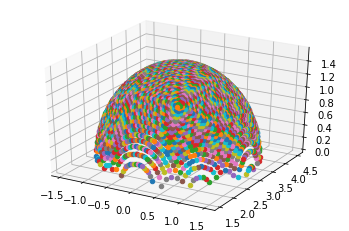

In [209]:
fig = plt.figure()
ax = fig.add_subplot( projection='3d')
for o in left_eye.ommatidia:
  ax.scatter(o.point.x, o.point.y, o.point.z)

plt.show()

Níže jsou jen pomocné funkce pro vektorovou matematiku a funkce pro výpočet průsečíku ve 3D. Jedná se jen o "nutné zlo", které není v žádné knihovně, proto musí být zde.

In [210]:
#  Genericke vektorove funkce

def add_v3v3(v0, v1):
    return (v0[0] + v1[0], v0[1] + v1[1], v0[2] + v1[2])

def sub_v3v3(v0, v1):
    return (v0[0] - v1[0], v0[1] - v1[1], v0[2] - v1[2])

def dot_v3v3(v0, v1):
    return ((v0[0] * v1[0]) + (v0[1] * v1[1]) + (v0[2] * v1[2]))

def len_squared_v3(v0):
    return dot_v3v3(v0, v0)

def mul_v3_fl(v0, f):
    return (v0[0] * f, v0[1] * f, v0[2] * f)

# Prusecik bodu a roviny
def isect_line_plane_v3(p0, p1, p_co, p_no, epsilon=1e-6):
    u = sub_v3v3(p1, p0)
    dot = dot_v3v3(p_no, u)

    if abs(dot) > epsilon:
        w = sub_v3v3(p0, p_co)
        fac = -dot_v3v3(p_no, w) / dot
        u = mul_v3_fl(u, fac)
        return add_v3v3(p0, u)
    else:
        return None



Před finálním vytvořením obrazu potřebujeme i nějaké pomocné funkce: primárně na překlad souřadnic modelu do souřadnic obrazu "terénu" a obrazu "oka". 

Poslední funkce se dále stará o výpočet hodnoty, kterou oko vidí - konkrétně jako průměr hodnot pixelů v nějaké vzdálenosti od středu. Střed je přitom průsečík obrazu terénu a přímky, která vychází kolmo ze středu ommatidia.

In [211]:
def translate(vector, center, img, pxpmm=1):
  rows = img.shape[0]
  cols = img.shape[1]
  step = 2*r/sqrt(num_omm)
  
  return int((pxpmm*(-(vector.y-center.y)/step+rows/(2*pxpmm)))), int(pxpmm*((vector.x-center.x)/step+cols/(2*pxpmm)))
  
def translate_img(vector, center, img, pxpmm=1):
  rows = img.shape[0]
  cols = img.shape[1]
  new_r = int(pxpmm*(-(vector.y-center.y) +rows/(2*pxpmm))) 
  new_c = int(pxpmm*( (vector.x-center.x) + cols/(2*pxpmm)))
  return new_r, new_c 

def in_image(point, img):
  if point[0] >= img.shape[0] or point[0] < 0 or point[1] >= img.shape[1] or point[1] < 0:
    return False
  else:
     return True

def get_avg(px):
  acc = np.zeros(3)
  for row in range(px[0]-acc_radius, px[0]+acc_radius):
    for col in range(px[1]-acc_radius, px[1]+acc_radius):
        if in_image([row, col], image):
          acc += image[row, col]
  return acc/(4*acc_radius**2)  

Nyní se dostáváme k samotnému jádru simulace. 

Funkce raycast (i když toto jméno si asi plně nezaslouží) vyšle paprsek z ommatidia (kolmo na fazetu) a spočítá, ve kterém bodě se paprsek protne s obrazem terénu. V tomto místě se poté spočítá průměrná hodnota v nějakém radiu, podle akceptačního úhlu ommatidia. 

Pokud paprsek nenarazí do obrazu terénu, je ponechána defaultní "bílá" hodnota. 

Funkce get_view přitom funguje jako ekvivalent zrakového nervu - jednoduše řečeno, z informací, které jsou obsaženy v každém z ommatidií sestaví výsledný obraz. 

In [212]:
def raycast(eye):
  for i in range(len(eye.ommatidia)):
    ise = isect_line_plane_v3(eye.ommatidia[i].point.data, eye.center.data, [0,0,z0], [0,0,1])
    if ise is None:
      continue
    ise = Vector(ise)
    row, col = translate_img(ise, Vector([0,0,0]), image, int(resolution/25))
    if not in_image([row, col], image):
      continue
    else:
      eye.ommatidia[i].value = get_avg([row,col])
  return eye

def get_view(eye, view):
  for o in eye.ommatidia:
    new_x, new_y = translate(o.point, eye.center, view)
    view[new_x, new_y] = o.value
  return view

In [213]:
# Priprava pro vytvoreni finalniho obrazu

view_left = np.zeros((int(sqrt(num_omm)) ,int(sqrt(num_omm)),3), np.uint8)
view_right = np.zeros((int(sqrt(num_omm)) ,int(sqrt(num_omm)),3), np.uint8)

max_x = sqrt(num_omm)
max_y = sqrt(num_omm)
min_y = 0
min_x = 0



## Finále

Níže dojde k samotnému vytvoření obrazu. Pro každé oko se nejprve funkcí raycast() vytvoří informace o tom, co které ommatidium vidí a následně se pomocí funkce get_view() vytvoří obraz, který lze zobrazit. 

Dále následuje jen postprocessing. 

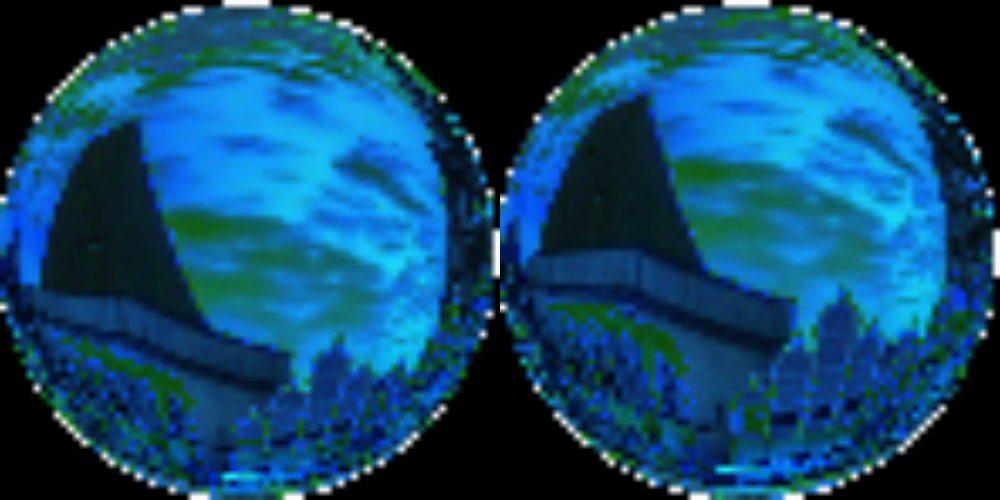

In [214]:
left_eye = raycast(left_eye)
view_left = get_view(left_eye, view_left)

right_eye = raycast(right_eye)
view_right = get_view(right_eye, view_right)

# Postprocessing. Zvetseni obrazu, jejich spojeni do jednoho 
view_left = cv.resize(view_left, (500,500))
view_right = cv.resize(view_right, (500,500))
v = cv.hconcat([view_left, view_right])
cv2_imshow(v)
